In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
CUTOFF = "2019-01-01"

df_pre = df.loc[df.index < CUTOFF].copy()
df_post = df.loc[df.index >= CUTOFF].copy()

print(f"Full sample:    {df.index[0].date()} → {df.index[-1].date()}  (T = {len(df)})")
print(f"Pre-2019:       {df_pre.index[0].date()} → {df_pre.index[-1].date()}  (T = {len(df_pre)})")
print(f"Post-2019:      {df_post.index[0].date()} → {df_post.index[-1].date()}  (T = {len(df_post)})")

Full sample:    1996-03-01 → 2024-08-01  (T = 342)
Pre-2019:       1996-03-01 → 2018-12-01  (T = 274)
Post-2019:      2019-01-01 → 2024-08-01  (T = 68)


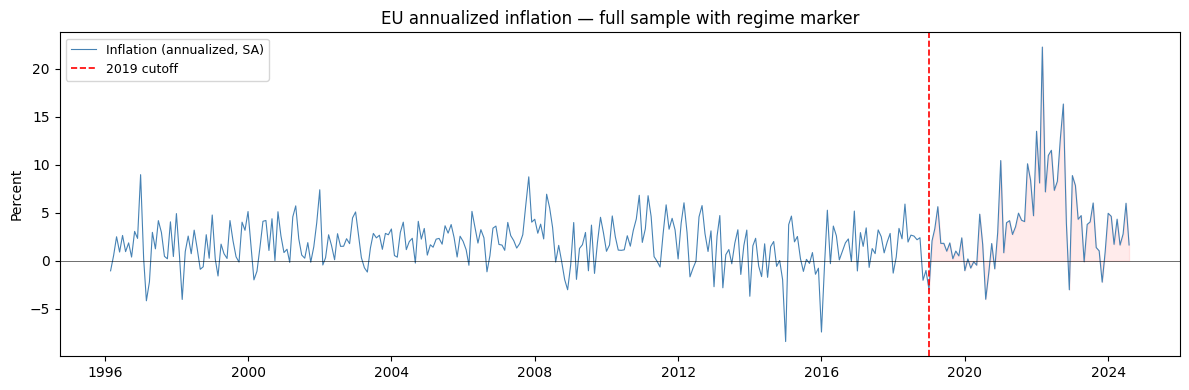

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df.index, df["i"], lw=0.8, color="steelblue", label="Inflation (annualized, SA)")
ax.axvline(pd.Timestamp(CUTOFF), color="red", ls="--", lw=1.2,
           label="2019 cutoff")
ax.axhline(0, color="black", lw=0.4)
ax.fill_between(df.index, df["i"], 0,
                where=df.index >= pd.Timestamp(CUTOFF),
                alpha=0.08, color="red")

ax.set_title("EU annualized inflation — full sample with regime marker")
ax.set_ylabel("Percent")
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()


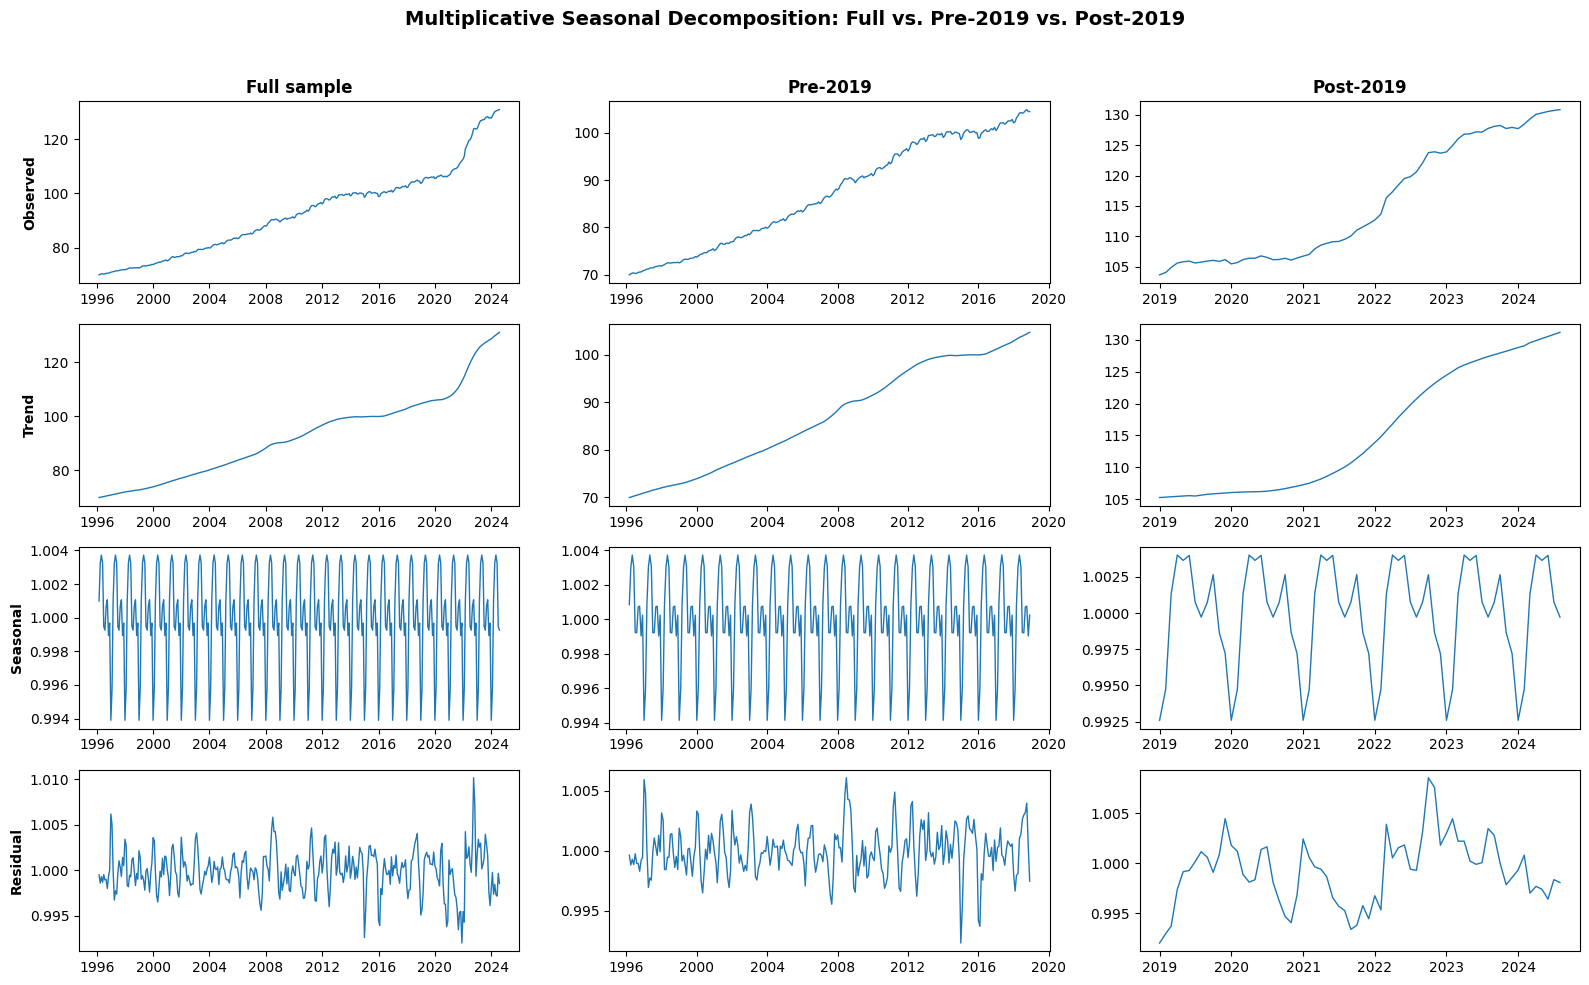

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(16, 10), sharex=False)
fig.suptitle("Multiplicative Seasonal Decomposition: Full vs. Pre-2019 vs. Post-2019",
             fontsize=14, fontweight="bold")
datasets = [
    ("Full sample", df["OBS_VALUE"]),
    ("Pre-2019", df.loc[df.index < CUTOFF, "OBS_VALUE"]),
    ("Post-2019", df.loc[df.index >= CUTOFF, "OBS_VALUE"]),
]

for col, (label, data_slice) in enumerate(datasets):
    dec = seasonal_decompose(data_slice, model="multiplicative",
                             period=12, extrapolate_trend="freq")

    components = [
        (dec.observed, "Observed"),
        (dec.trend, "Trend"),
        (dec.seasonal, "Seasonal"),
        (dec.resid, "Residual")
    ]

    for row, (comp, cname) in enumerate(components):
        ax = axes[row, col]
        ax.plot(comp, lw=1.0)
        if col == 0:
            ax.set_ylabel(cname, fontsize=10, fontweight="bold")
        if row == 0:
            ax.set_title(label, fontsize=12, fontweight="bold")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
lags_list = [2, 4, 6, 8, 12]

for label, series in [("Full sample", df["i"]), ("Pre-2019", df_pre["i"])]:
    rows = [adf_with_lags(series, L) for L in lags_list]
    tbl = pd.DataFrame(rows)
    print(f"\nADF test: {label}")
    print(tbl.to_string(index=False, float_format=lambda z: f"{z: .4f}"))


ADF test: Full sample
 lags  adf_stat  p_value  crit_5  crit_10
    2   -6.7557   0.0000 -2.8701  -2.5713
    4   -4.6676   0.0001 -2.8702  -2.5714
    6   -3.3131   0.0143 -2.8702  -2.5714
    8   -3.3919   0.0112 -2.8703  -2.5714
   12   -3.3128   0.0143 -2.8704  -2.5715

ADF test: Pre-2019
 lags  adf_stat  p_value  crit_5  crit_10
    2   -8.8911   0.0000 -2.8723  -2.5725
    4   -6.9212   0.0000 -2.8723  -2.5725
    6   -4.8077   0.0001 -2.8724  -2.5726
    8   -4.1350   0.0008 -2.8725  -2.5726
   12   -3.0179   0.0333 -2.8727  -2.5727


The pre-2019 sample rejects the unit root far more decisively than the full sample at every lag length: −8.89 vs. −6.76 at 2 lags, −4.81 vs. −3.31 at 6 lags. Pre-2019 EU inflation is unambiguously stationary. The full sample still rejects, but the statistics are weaker. The post-2019 episode is pulling the series toward unit-root behaviour, making rejections more marginal.

In [ ]:
bandwidth_list = ["auto", 2, 4, 6, 8, 12]

for label, series in [("Full sample", df["i"]), ("pre-2019", df_pre["i"])]:
    rows = [kpss_with_bandwidth(series, regression="c", nlags=bw)
            for bw in bandwidth_list]
    tbl = pd.DataFrame(rows)
    print(f"\nKPSS test: {label}")
    print(tbl.to_string(index=False, float_format=lambda z: f"{z: .4f}"))


KPSS test: Full sample
 nlags  kpss_stat  p_value  crit_5  crit_10 nlags_choice
     9     0.3909   0.0811  0.4630   0.3470         auto
     2     0.8521   0.0100  0.4630   0.3470            2
     4     0.6376   0.0192  0.4630   0.3470            4
     6     0.5052   0.0405  0.4630   0.3470            6
     8     0.4199   0.0686  0.4630   0.3470            8
    12     0.3272   0.1000  0.4630   0.3470           12

KPSS test: pre-2019
 nlags  kpss_stat  p_value  crit_5  crit_10 nlags_choice
     2     0.3524   0.0977  0.4630   0.3470         auto
     2     0.3524   0.0977  0.4630   0.3470            2
     4     0.3449   0.1000  0.4630   0.3470            4
     6     0.3218   0.1000  0.4630   0.3470            6
     8     0.2926   0.1000  0.4630   0.3470            8
    12     0.2525   0.1000  0.4630   0.3470           12


Pre-2019 never rejects stationarity at 5% regardless of bandwidth. The full sample rejects at low bandwidths (nlags 2–6). So the two tests agree for pre-2019 (stationary).

Following Verbeek (2017), we note that unit-root conclusions for inflation are sensitive to the choice of lag length (ADF) and bandwidth (KPSS), and accordingly treat these tests as diagnostics rather than definitive verdicts.

Pre-2019 inflation is clearly I(0). Including the post-2019 turbulence weakens the stationarity evidence.

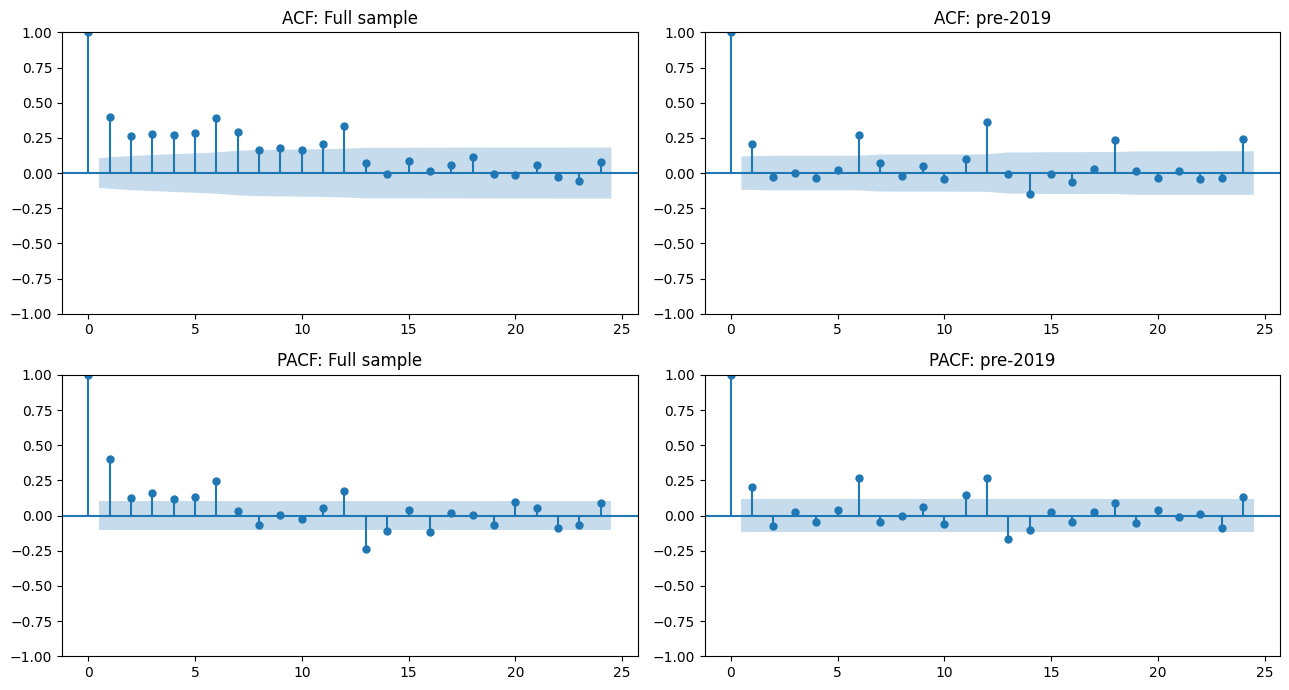

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(13, 7))

for col, (label, series) in enumerate([("Full sample", df["i"]),
                                        ("pre-2019", df_pre["i"])]):
    sm.graphics.tsa.plot_acf(series, lags=24, ax=axes[0, col],
                              title=f"ACF: {label}")
    sm.graphics.tsa.plot_pacf(series, lags=24, method="ywm",
                               ax=axes[1, col],
                               title=f"PACF: {label}")

plt.tight_layout()
plt.show()

In [ ]:
MAX_P = 12

persistence_results = {}

for label, series in [("Full sample", df["i"]), ("pre-2019", df_pre["i"])]:
    rows = []
    for p in range(1, MAX_P + 1):
        model = AutoReg(series, lags=p, trend="c").fit()

        # AR coefficients (skip the constant at index 0)
        ar_coefs = model.params[1:]
        sarc = ar_coefs.sum()

        # Cumulative impulse response
        cir = 1.0 / (1.0 - sarc) if abs(sarc) < 1 else np.inf

        # Half-life (defined only for 0 < SARC < 1)
        if 0 < sarc < 1:
            half_life = np.log(0.5) / np.log(sarc)
        else:
            half_life = np.nan

        # Ljung-Box on residuals
        lb = acorr_ljungbox(model.resid, lags=[10], return_df=True)
        lb_pval = lb["lb_pvalue"].iloc[0]

        rows.append({
            "p": p,
            "AIC": round(model.aic, 2),
            "BIC": round(model.bic, 2),
            "LB_pval": round(lb_pval, 4),
            "SARC": round(sarc, 4),
            "CIR": round(cir, 3) if np.isfinite(cir) else np.inf,
            "half_life": round(half_life, 1) if not np.isnan(half_life) else np.nan,
        })

    tbl = pd.DataFrame(rows)
    persistence_results[label] = tbl

    print(f"  {label}")
    print(tbl.to_string(index=False))

    best_aic = int(tbl.loc[tbl["AIC"].idxmin(), "p"])
    best_bic = int(tbl.loc[tbl["BIC"].idxmin(), "p"])
    print(f"\n  Best by AIC: AR({best_aic})    Best by BIC: AR({best_bic})")

  Full sample
 p     AIC     BIC  LB_pval   SARC   CIR  half_life
 1 1676.91 1688.40   0.0000 0.4006 1.668        0.8
 2 1669.80 1685.12   0.0000 0.4738 1.900        0.9
 3 1658.57 1677.70   0.0005 0.5606 2.276        1.2
 4 1652.00 1674.94   0.0009 0.6110 2.571        1.4
 5 1643.68 1670.42   0.0291 0.6647 2.983        1.7
 6 1620.60 1651.14   0.9444 0.7466 3.947        2.4
 7 1618.30 1652.63   0.9927 0.7561 4.100        2.5
 8 1614.73 1652.84   0.9928 0.7383 3.821        2.3
 9 1612.71 1654.60   0.9934 0.7404 3.852        2.3
10 1610.66 1656.32   0.9865 0.7333 3.750        2.2
11 1601.12 1650.54   0.9815 0.7514 4.022        2.4
12 1586.36 1639.55   0.8399 0.7971 4.927        3.1

  Best by AIC: AR(12)    Best by BIC: AR(12)
  pre-2019
 p     AIC     BIC  LB_pval   SARC   CIR  half_life
 1 1226.47 1237.30   0.0026 0.2048 1.258        0.4
 2 1223.53 1237.95   0.0054 0.1461 1.171        0.4
 3 1221.79 1239.80   0.0083 0.1675 1.201        0.4
 4 1219.59 1241.18   0.0144 0.1292 1.148     

In [ ]:
CHOSEN_P = 6

comparison_rows = []
for label, tbl in persistence_results.items():
    for _, row in tbl.iterrows():
        if row["p"] <= CHOSEN_P:
            comparison_rows.append({"Sample": label, **row.to_dict()})

comparison_df = pd.DataFrame(comparison_rows)
print(f"\nFull vs. Pre-2019  (p = 1, …, {CHOSEN_P})")
print(comparison_df.to_string(index=False))



Full vs. Pre-2019  (p = 1, …, 6)
     Sample   p     AIC     BIC  LB_pval   SARC   CIR  half_life
Full sample 1.0 1676.91 1688.40   0.0000 0.4006 1.668        0.8
Full sample 2.0 1669.80 1685.12   0.0000 0.4738 1.900        0.9
Full sample 3.0 1658.57 1677.70   0.0005 0.5606 2.276        1.2
Full sample 4.0 1652.00 1674.94   0.0009 0.6110 2.571        1.4
Full sample 5.0 1643.68 1670.42   0.0291 0.6647 2.983        1.7
Full sample 6.0 1620.60 1651.14   0.9444 0.7466 3.947        2.4
   pre-2019 1.0 1226.47 1237.30   0.0026 0.2048 1.258        0.4
   pre-2019 2.0 1223.53 1237.95   0.0054 0.1461 1.171        0.4
   pre-2019 3.0 1221.79 1239.80   0.0083 0.1675 1.201        0.4
   pre-2019 4.0 1219.59 1241.18   0.0144 0.1292 1.148        0.3
   pre-2019 5.0 1217.43 1242.59   0.0291 0.1685 1.203        0.4
   pre-2019 6.0 1195.70 1224.43   0.9511 0.3899 1.639        0.7


Ljung–Box column: AR(1)–AR(5) fail the residual diagnostic, then AR(6) is the first model that passes (LB p-value = 0.94 on the full sample, 0.95 on pre-2019). Every model from AR(7) onward also passes, but it's not adding anything. The residuals were already clean at p = 6. Even if AIC and BIC metrics suggest to chose higher order, it will not have any plus-value to the model rather than modeling the noise and add complexity to the interpretation.

Pre-2019 EU inflation was low-persistence: SARC ≈ 0.39, meaning shocks dissipated quickly (half-life under 1 month, cumulative effect only 1.64× the initial impulse). When we include the post-2019 data, SARC nearly doubles to 0.75 and shocks now take 2.4 months to halve and cumulate to nearly 4× their initial size.
We note that this pattern is consistent across all AR orders in the table:
at every p from 1 to 6, the full-sample SARC exceeds the pre-2019 SARC by 15–35 percentage points.

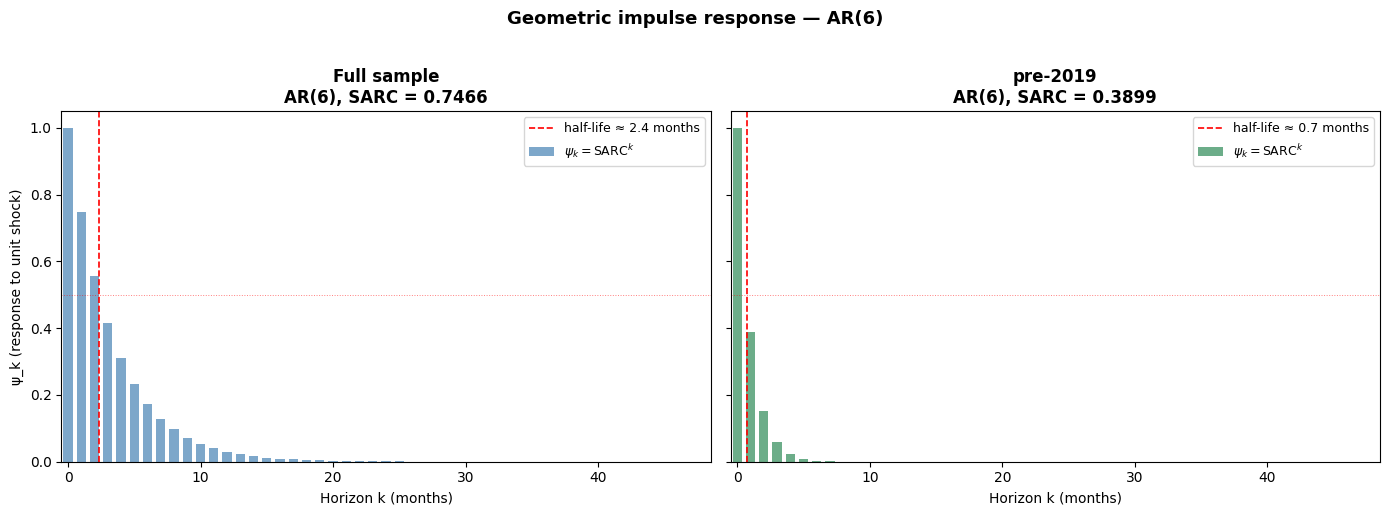


Full sample: AR(6), SARC = 0.7466
  ψ_0  = 1.0000
  ψ_3  = 0.4162
  ψ_6  = 0.1732
  ψ_12 = 0.0300
  ψ_24 = 0.0009
  half-life = 2.4 months

pre-2019: AR(6), SARC = 0.3899
  ψ_0  = 1.0000
  ψ_3  = 0.0593
  ψ_6  = 0.0035
  ψ_12 = 0.0000
  ψ_24 = 0.0000
  half-life = 0.7 months


In [ ]:
IRF_HORIZON = 48
CHOSEN_P = 6

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for idx, (label, tbl) in enumerate(persistence_results.items()):
    sarc = tbl.loc[tbl["p"] == CHOSEN_P, "SARC"].iloc[0]

    k   = np.arange(IRF_HORIZON + 1)
    irf = sarc ** k

    hl = np.log(0.5) / np.log(sarc) if 0 < sarc < 1 else np.nan

    ax = axes[idx]
    ax.bar(k, irf, width=0.7, alpha=0.7,
           color="steelblue" if idx == 0 else "seagreen",
           label=r"$\psi_k = \mathrm{SARC}^{k}$")
    ax.axhline(0, color="black", lw=0.5)

    if not np.isnan(hl):
        ax.axvline(hl, color="red", ls="--", lw=1.2,
                   label=f"half-life ≈ {hl:.1f} months")
        ax.axhline(0.5, color="red", ls=":", lw=0.7, alpha=0.5)

    ax.set_title(f"{label}\nAR({CHOSEN_P}), SARC = {sarc:.4f}",
                 fontweight="bold")
    ax.set_xlabel("Horizon k (months)")
    ax.set_xlim(-0.5, IRF_HORIZON + 0.5)
    ax.legend(fontsize=9)

axes[0].set_ylabel("ψ_k (response to unit shock)")
fig.suptitle(f"Geometric impulse response — AR({CHOSEN_P})",
             fontsize=13, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

for label, tbl in persistence_results.items():
    sarc = tbl.loc[tbl["p"] == CHOSEN_P, "SARC"].iloc[0]
    hl   = np.log(0.5) / np.log(sarc) if 0 < sarc < 1 else np.nan
    print(f"\n{label}: AR({CHOSEN_P}), SARC = {sarc:.4f}")
    for h in [0, 3, 6, 12, 24]:
        print(f"  ψ_{h:<2d} = {sarc**h:.4f}")
    if not np.isnan(hl):
        print(f"  half-life = {hl:.1f} months")

The full-sample panel shows bars that remain visible out to about k = 20 months, while the pre-2019 panel collapses to near-zero by k = 3–4. The red dashed half-life line confirms this visually: it sits at 2.4 months for the full sample but at 0.7 months for pre-2019, meaning pre-2019 shocks halved in about three weeks.



*   After 3 months, 42% of the shock survives (full) vs. 6% (pre-2019)
*   After 6 months, 17% vs. essentially zero
*   After 1 year, 3% vs. zero
*   Shocks halve 3.4× faster pre-2019
*   Total cumulated effect is 2.4× larger for full sample


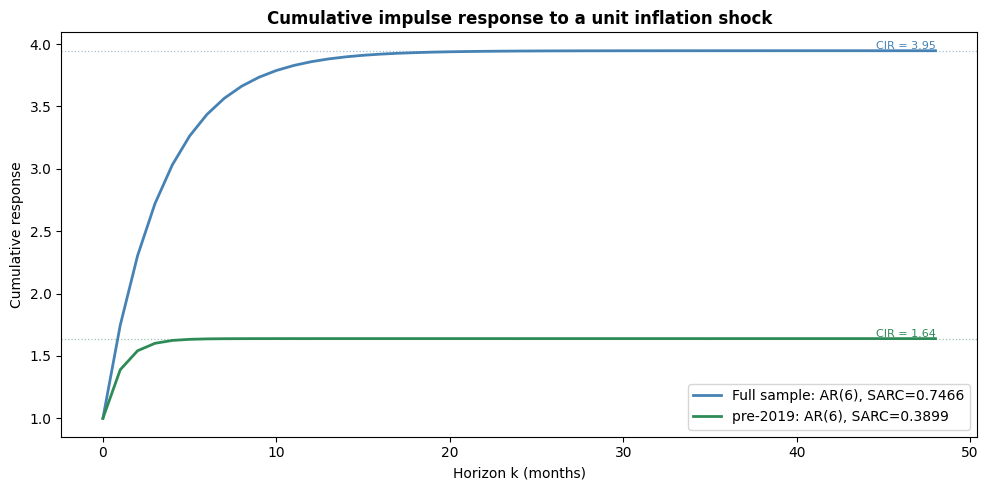

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

colors_map = {"Full sample": "steelblue", "pre-2019": "seagreen"}

for label, tbl in persistence_results.items():
    best_p = CHOSEN_P
    sarc = tbl.loc[tbl["p"] == CHOSEN_P, "SARC"].iloc[0]

    k    = np.arange(IRF_HORIZON + 1)
    irf  = sarc ** k
    cirf = np.cumsum(irf)

    color = colors_map[label]
    ax.plot(k, cirf, lw=2, color=color,
            label=f"{label}: AR({best_p}), SARC={sarc:.4f}")

    # Asymptotic CIR
    if abs(sarc) < 1:
        cir_inf = 1.0 / (1.0 - sarc)
        ax.axhline(cir_inf, color=color, ls=":", lw=0.9, alpha=0.5)
        ax.annotate(f"CIR = {cir_inf:.2f}", xy=(IRF_HORIZON, cir_inf),
                    fontsize=8, color=color, va="bottom", ha="right")

ax.set_xlabel("Horizon k (months)")
ax.set_ylabel("Cumulative response")
ax.set_title("Cumulative impulse response to a unit inflation shock",
             fontweight="bold")
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

The green curve (pre-2019) flattens almost immediately at CIR = 1.64: a 1 pp inflation shock cumulates to a total of 1.64 pp across all horizons, and the process is essentially done within 4 months. The blue curve (full sample) keeps climbing for 15+ months before plateauing at CIR = 3.95. Same initial shock, but 2.4× more cumulated inflation. The gap between these two curves is the post-2019 effect on persistence.

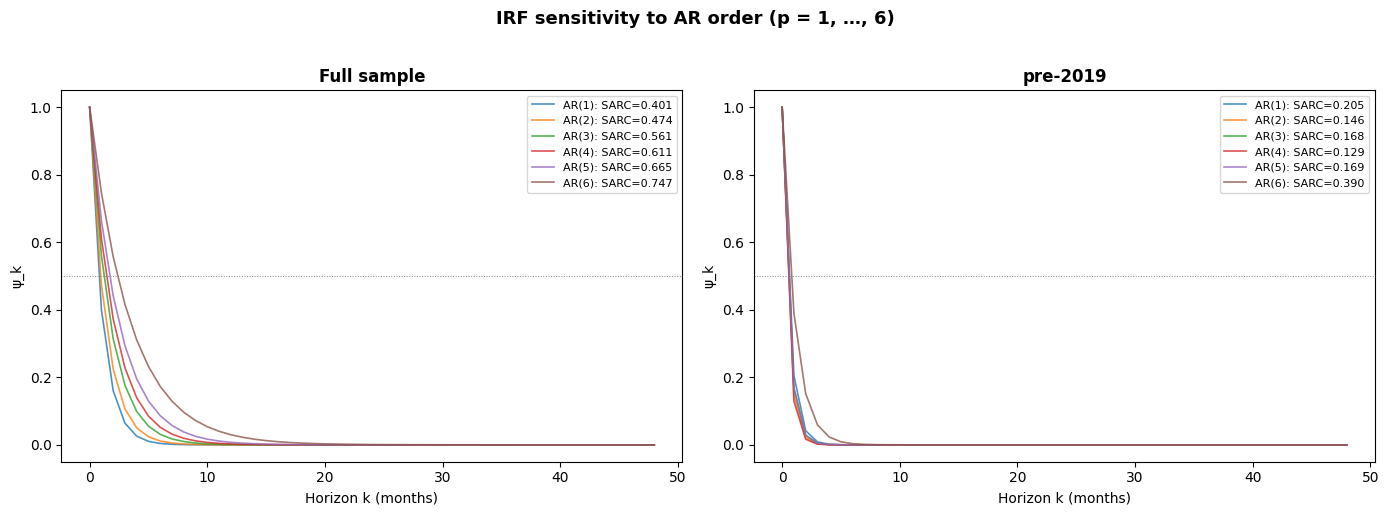

In [ ]:
CHOSEN_P = 6

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for col, (label, tbl) in enumerate(persistence_results.items()):
    ax = axes[col]
    k = np.arange(IRF_HORIZON + 1)

    for _, row in tbl[tbl["p"] <= CHOSEN_P].iterrows():
        p    = int(row["p"])
        sarc = row["SARC"]
        ax.plot(k, sarc ** k, lw=1.2, alpha=0.8,
                label=f"AR({p}): SARC={sarc:.3f}")

    ax.axhline(0.5, color="gray", ls=":", lw=0.7)
    ax.set_title(label, fontweight="bold")
    ax.set_xlabel("Horizon k (months)")
    ax.set_ylabel("ψ_k")
    ax.legend(fontsize=8, loc="upper right")

fig.suptitle(f"IRF sensitivity to AR order (p = 1, …, {CHOSEN_P})",
             fontsize=13, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

 First, the full-sample panel shows a clear fan of curves (SARC rising steadily from 0.40 to 0.75 as p increases). Persistence estimates are sensitive to the number of lags included. Second, the pre-2019 panel shows that AR(1)–AR(5) are all clustered tightly together at very low SARC (0.13–0.21), then AR(6) jumps to 0.39. This jump happens because lag 6 captures a residual half-yearly seasonal pattern that lags 1–5 miss. Even so, 0.39 is still low persistence. Regardless of which AR order to pick, the full sample is always substantially more persistent than pre-2019.

Pre-2019, EU inflation behaved like a well-anchored process  (shocks from energy prices, VAT changes, or food prices were absorbed within a few months) consistent with firmly anchored expectations and a credible ECB target. Including the post-2019 period (COVID supply disruptions, the 2021–22 energy surge, delayed ECB tightening) roughly doubles measured persistence. Shocks propagated for much longer, likely through second-round effects: wage catch-up, more frequent firm re-pricing, and temporarily de-anchored expectations. The cumulative IRF plot shows this most clearl, the same initial shock produces 2.4 times more cumulated inflation when the post-2019 episode is included.